In [2]:
import numpy as np
import pandas as pd

import jax
import jax.numpy as jnp
from scipy.signal import fftconvolve

import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('./data/bbc_text_cls.csv')
maxlen = np.quantile(df.text.apply(len), q=0.99)
print(len(df))
df = df[df.text.apply(len) < maxlen].reset_index()
df

2225


,index,text,labels
0,0,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,1,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,2,Yukos unit buyer faces loan claim\n\nThe owner...,business
3,3,High fuel prices hit BA's profits\n\nBritish A...,business
4,4,Pernod takeover talk lifts Domecq\n\nShares in...,business
...,...,...,...
2197,2217,TV's future down the phone line\n\nInternet TV...,tech
2198,2218,Cebit fever takes over Hanover\n\nThousands of...,tech
2199,2220,BT program to beat dialler scams\n\nBT is intr...,tech
2200,2221,Spam e-mails tempt net shoppers\n\nComputer us...,tech


In [4]:
maxlen = 500

In [5]:
class ArticlesDataset():
    UNK_TOKEN = 'UNK'
    PAD_TOKEN = 'PAD'

    @staticmethod
    def preprocess_text(text: str) -> list[str]:
        text = text.lower()  # lower characters
        text = re.sub(r'[^a-zA-Z]', ' ', text)  # remove special characters
        text_tokenized = word_tokenize(text)  # split by words

        lemmatizer = WordNetLemmatizer()  # lemmatize
        text_tokenized = [lemmatizer.lemmatize(word) for word in text_tokenized]

        english_stopwords = set(stopwords.words("english"))    # remove stopwords
        text_tokenized = [word for word in text_tokenized if word not in english_stopwords]
        return text_tokenized

    @classmethod
    def create_vocab(cls, texts: list[list[str]]) -> dict:
        vocab = {
            cls.UNK_TOKEN: 0,
            cls.PAD_TOKEN: 1,
        }
        for text in texts:
            for word in text:
                vocab[word] = vocab.get(word, len(vocab))
        return vocab

    @property
    def unk_token_id(self):
        return self.vocab[self.UNK_TOKEN]

    @property
    def pad_token_id(self):
        return self.vocab[self.PAD_TOKEN]

    def __init__(self, data, maxlen):
        if maxlen is None:
            maxlen = data.text.apply(len).max()
        self.maxlen = maxlen
        texts_tokenized = data.text.apply(self.preprocess_text).to_list()

        self.vocab = self.create_vocab(texts_tokenized)

        unique_labels = set(data.labels.to_list())
        self.labels_vocab = {label: idx for idx, label in enumerate(unique_labels)}
        self.labels = data.labels.apply(lambda x: self.labels_vocab[x])

        self.data = np.full((len(texts_tokenized), self.maxlen), fill_value=self.pad_token_id)
        for text_idx, text in enumerate(texts_tokenized):
            for word_idx, word in enumerate(text):
                if word_idx >= self.maxlen:
                    break
                self.data[text_idx][word_idx] = self.vocab[word]

        self.data = jnp.array(self.data)
        self.labels = jnp.array(self.labels)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        tokens = self.data[index]
        label = self.labels[index]

        tokens = jnp.array(tokens)
        label = jnp.array(label)
        return tokens, label

In [6]:
def create_context_coeff_matrix(ctx_len, seq_len):
    gamma = 1 / ctx_len

    # construct tril matrix (suffix context)
    tril_matrix = np.zeros((seq_len, seq_len))
    for i in np.arange(1, ctx_len + 1):
        tril_matrix[np.arange(i, seq_len), np.arange(seq_len - i)] = gamma * (1 - gamma) ** i

    # contstruct full matrix (self + prefix + suffix context)
    full_matrix = np.eye(tril_matrix.shape[0]) * gamma + tril_matrix + tril_matrix.T

    # normalize weights and transpose
    full_matrix /= full_matrix.sum(axis=0)
    full_matrix = full_matrix.T
    return jnp.array(full_matrix)

In [7]:
dataset = ArticlesDataset(df, maxlen=maxlen)
len(dataset)

2202

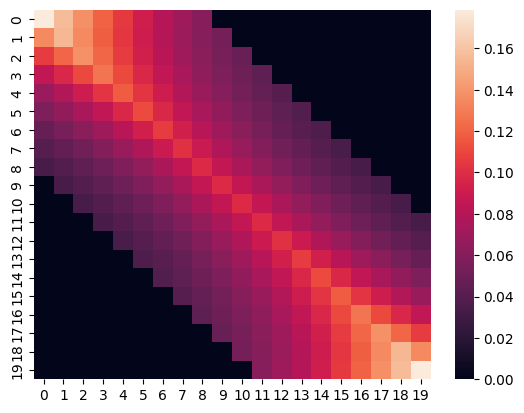

In [8]:
cf = create_context_coeff_matrix(ctx_len=8, seq_len=20)
sns.heatmap(cf)
plt.show()

In [9]:
a = np.array([[2, 3], [4, 5]])

b = np.array([0, 0, 1, 0])

np.take_along_axis(a, b[:, None], axis=0)

array([[2, 3],
       [2, 3],
       [4, 5],
       [2, 3]])

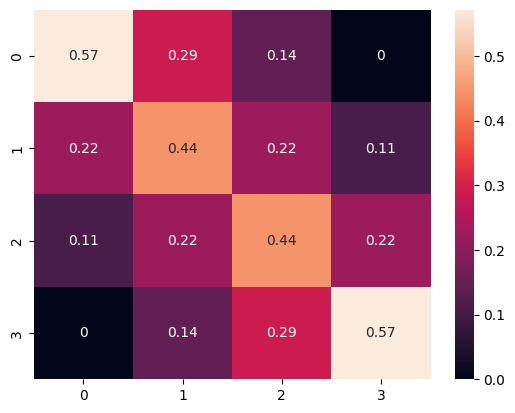

In [10]:
cf = create_context_coeff_matrix(ctx_len=2, seq_len=4)
sns.heatmap(cf, annot=True)
plt.show()

In [12]:
tensor = jnp.array([
    [[1, 1], [2, 2], [3, 3], [4, 4]],
    # 0.57 * [1, 1] + 0.29 * [2, 2] + 0.14 * [3, 3] + 0    * [4, 4] = [1.57, 1.57]
    # 0.22 * [1, 1] + 0.44 * [2, 2] + 0.22 * [3, 3] + 0.11 * [4, 4] = [2.2, 2.2]
    # 0.11 * [1, 1] + 0.22 * [2, 2] + 0.44 * [3, 3] + 0.22 * [4, 4] = [2.75, 2.75]
    # 0    * [1, 1] + 0.14 * [2, 2] + 0.29 * [3, 3] + 0.57 * [4, 4] = [3.43, 3.43]
    [[1, 2], [3, 4], [5, 6], [8, 9]],
])
# res = np.einsum('hwk,wj->hwk', tensor, cf)
# res = np.dot(tensor, cf[None, ...])
res = fftconvolve(tensor[:, None, :, :], cf[::-1][None, :, :, None], mode='valid', axes=[2, 3])
# res = res.sum(axis=2)
res.shape, res

((2, 4, 1, 2),
 array([[[[1.57142856, 1.57142856]],
 
         [[2.22222224, 2.22222224]],
 
         [[2.77777777, 2.77777777]],
 
         [[3.42857149, 3.42857149]]],
 
 
        [[[2.14285711, 3.14285711]],
 
         [[3.55555558, 4.55555559]],
 
         [[4.77777777, 5.77777777]],
 
         [[6.42857155, 7.42857157]]]]))

In [10]:
tensor = np.array([
    [[1, 1], [2, 2], [3, 3], [4, 4]],
    # 0.57 * [1, 1] + 0.29 * [2, 2] + 0.14 * [3, 3] + 0    * [4, 4] = [1.57, 1.57]
    # 0.22 * [1, 1] + 0.44 * [2, 2] + 0.22 * [3, 3] + 0.11 * [4, 4] = [2.2, 2.2]
    # 0.11 * [1, 1] + 0.22 * [2, 2] + 0.44 * [3, 3] + 0.22 * [4, 4] = [2.75, 2.75]
    # 0    * [1, 1] + 0.14 * [2, 2] + 0.29 * [3, 3] + 0.57 * [4, 4] = [3.43, 3.43]
    [[1, 2], [3, 4], [5, 6], [8, 9]],
])
# res = np.einsum('hwk,wj->hwk', tensor, cf)
# res = np.dot(tensor, cf[None, ...])
res = fftconvolve(tensor[:, None, :, :], cf[::-1][None, :, :, None], mode='valid')
# res = res.sum(axis=2)
res.shape, res

((2, 4, 1, 2),
 array([[[[1.57142856, 1.57142856]],
 
         [[2.22222224, 2.22222224]],
 
         [[2.77777777, 2.77777777]],
 
         [[3.42857149, 3.42857149]]],
 
 
        [[[2.14285711, 3.14285711]],
 
         [[3.55555558, 4.55555559]],
 
         [[4.77777777, 5.77777777]],
 
         [[6.42857155, 7.42857157]]]]))

In [11]:
res.reshape(-1, res.shape[-1])

array([[1.57142856, 1.57142856],
       [2.22222224, 2.22222224],
       [2.77777777, 2.77777777],
       [3.42857149, 3.42857149],
       [2.14285711, 3.14285711],
       [3.55555558, 4.55555559],
       [4.77777777, 5.77777777],
       [6.42857155, 7.42857157]])

In [12]:
@jax.jit
def _norm(x: jnp.ndarray):
    # take x+ = max(x, 0) element-wise (perform projection on positive simplex)
    x = jnp.maximum(x, jnp.zeros_like(x))
    # normalize values in non-zero rows to 1 (mapping from the positive simplex to the unit simplex)
    norm = x.sum(axis=0)
    x = jnp.where(norm > 1e-12, x / norm, x)
    return x

_norm(
    jnp.array([
        [1, -1, 1, 2],
        [1, 3, -4, 3],
    ])
)

Array([[0.5, 0. , 1. , 0.4],
       [0.5, 1. , 0. , 0.6]], dtype=float32)

In [13]:
indices = np.array([0, 0, 0, 1, 2, 1, 3, 2])
values = np.array([[0.1, 0.3], [2, 4], [5, 2], [1, 0]])

# Create a one-hot encoding of the indices
one_hot_indices = np.eye(indices.max() + 1)[indices]

# Multiply the one-hot encoding by the values
multiplied_values = values * one_hot_indices.sum(axis=0)[:, None]

print(multiplied_values)  # Output: [0.2, 4, 0.1, 10]

[[ 0.3  0.9]
 [ 4.   8. ]
 [10.   4. ]
 [ 1.   0. ]]


In [18]:
class ContextTopicModel():
    """
    Topic model which uses local context of words
    """

    def __init__(
            self,
            ctx_len: int,
            max_len: int,
            vocab_size: int,
            n_topics: int = 10,
            reg_list: list = None,
            eps: float = 1e-12,
    ):
        """
        Args:
            ctx_len: one-sided context size
            max_len: max length of a document, W_d
            vocab_size: corpus vocabulary size, W
            n_topics: number of topics, T
            regularizations: list of regularizations (see `add_regularization` method)
            eps: parameter set for balance between numerical stability and precision

        Note:
            - Total context of a word on `i`-th index is ctx_len words to the left,\\
            `ctx_len` words to the right, and the word itself
            - All documents should be padded to `max_len` length
        """
        self.ctx_len = ctx_len
        self.seq_len = max_len
        self.n_topics = n_topics
        self.vocab_size = vocab_size
        self._eps = eps

        self._context_coeffs = self._create_context_coeff_matrix()

        self._regularizations = dict()
        if reg_list is not None:
            for reg in reg_list:
                self.add_regularization(reg)

    def _norm(self, x: jnp.ndarray) -> jnp.ndarray:
        # take x+ = max(x, 0) element-wise (perform projection on positive simplex)
        x = jnp.maximum(x, jnp.zeros_like(x))
        # normalize values in non-zero rows to 1 (mapping from the positive simplex to the unit simplex)
        norm = x.sum(axis=0)
        x = jnp.where(norm > self._eps, x / norm, x)
        return x

    def _create_context_coeff_matrix(self) -> jnp.ndarray:
        gamma = 1 / self.ctx_len

        # construct tril matrix (suffix context)
        tril_matrix = np.zeros((self.seq_len, self.seq_len))
        for i in np.arange(1, self.ctx_len + 1):
            tril_matrix[np.arange(i, self.seq_len), np.arange(self.seq_len - i)] = gamma * (1 - gamma) ** i

        # contstruct full matrix (self + prefix + suffix context)
        full_matrix = np.eye(tril_matrix.shape[0]) * gamma + tril_matrix + tril_matrix.T

        # normalize weights and transpose
        full_matrix /= full_matrix.sum(axis=0)
        full_matrix = full_matrix.T
        return jnp.array(full_matrix)

    def add_regularization(self, reg, tag: str = None):
        """
        Add `reg` regularization to the model with `tag` identifier \\
        Note:
        - `reg` has to be a child of base `Regularization` class
        - `tag` will use the name of the class by default
        """
        if tag is None:
            tag = reg.__name__
        if not isinstance(reg, Regularization):
            raise TypeError(f'Regularization [{tag}] has to be a subclass of Regularization class')

        try:
            self._regularizations[tag] = jax.grad(reg)
        except Exception:
            raise

    def _compose_regularizations(self):
        regs = self._regularizations.values()
        sum_reg = lambda x: sum([1.0, ] + [reg(x) for reg in regs])
        return jax.grad(sum_reg)

    def fit(self, data: jnp.ndarray, max_iter: int = 1000, tol: float = 1e-3, seed: int = 0):
        """
        Args:
            data: matrix of shape (D, W_d), containing tokenized words of each document
            max_iter: max number of iterations
            tol: early stopping threshold
            seed: random seed
        """
        key = jax.random.key(seed)
        self.phi = jax.random.normal(
            key=key,
            shape=(self.vocab_size, self.n_topics),
        )  # (W, T)
        self.n_t = jnp.full(
            shape=(self.n_topics, ),
            fill_value=jnp.sum(data) / self.n_topics,
        )  # (T, )
        grad_regularization = self._compose_regularizations()

        for it in jnp.arange(max_iter):
            # Calculate phi' (words -> topics) matrix (phi with old p_{ti})
            phi_hatch = self._norm(self.phi.T * self.n_t[:, None]).T  # (W, T)

            # Create theta (documents -> topics) matrix
            # We can interpret phi as a bunch of embeddings for words,
            # thus creating tensor of embeddings of words in documents
            # and calculating context (document embedding), based on this
            data_emb = jnp.take_along_axis(phi_hatch[None, ...], indices=data[..., None], axis=1)  # (D, W_d, T)
            print(data_emb[:, None, :, :].shape, self._context_coeffs[::-1][None, :, :, None].shape)
            theta_new = fftconvolve(
                data_emb[:, None, :, :],
                self._context_coeffs[::-1][None, :, :, None],
                mode='valid',
                axes=[2, 3],
            )  # (D, W_d, 1, T)
            print(theta_new.shape)
            # Now we see each context window as a new document, I - number of context documents
            theta_new = theta_new.reshape(-1, theta_new.shape[-1])  # (I, T)

            # Update p_{ti} - topic probability distribution for i-th context
            data_emb = jnp.take_along_axis(self.phi[None, ...], indices=data[..., None], axis=1)  # (D, W, T)
            print(data_emb.shape)
            p_ti = data_emb.reshape(-1, data_emb.shape[-1]).T  # (T, I)
            p_ti = self._norm(p_ti * theta_new.T)  # (T, I)
            print(p_ti.shape)

            # Update n_{t} - topic probability distribution
            self.n_t = jnp.sum(p_ti, axis=1)  # (T, )
            print(self.n_t.shape)

            # Update phi (words -> topics) matrix (phi with new p_{ti})
            indices = data.flatten()  # (I, )

            # OHE-like indices for [w_i = w] indicator
            ohe = jnp.eye(self.vocab_size)[indices]  # (I, W)
            print(ohe.shape)
            phi_unregularized = (p_ti @ ohe).T  # (W, T)
            print(phi_unregularized.shape)
            phi_new = phi_unregularized + self.phi * grad_regularization(self.phi)  # (W, T)
            print(phi_new.shape)
            phi_new = self._norm(phi_new)  # (W, T)

            diff_norm = jnp.linalg.norm(phi_new - self.phi)
            print(f'Iteration [{it}/{max_iter}], diff_norm: {diff_norm:.04f}')
            self.phi = phi_new
            if diff_norm < tol:
                break

In [19]:
model = ContextTopicModel(
    ctx_len=5,
    max_len=maxlen,
    vocab_size=len(dataset.vocab),
    n_topics=10,
)
model.fit(dataset.data)

(2202, 1, 500, 10) (1, 500, 500, 1)


: 

In [12]:
# maxlen = 100, context = 5
topk = jnp.argsort(model.phi, axis=0, descending=True)[:10, :].T  # (T, W_{top})
reverse_vocab = {value: key for key, value in dataset.vocab.items()}

for t in topk:
    print('\t'.join([reverse_vocab[int(idx)] for idx in t]))
    print()

juxtaposed	affectionately	visually	demonised	kristin	turkmenistan	excerpt	rhodes	leadsnosoftwarepatents	indrawati

skin	holiff	flow	babe	hoey	routing	made	windy	fiszman	recycled

mom	biotech	bouncer	defends	denis	howley	policing	automaker	amnesty	course

dancefloor	zephyr	overestimated	uninterrupted	intellectual	trusting	penny	tranmere	argumentative	shooting

approve	font	mirvish	vima	wyatt	kort	happy	theoretically	fascination	payoff

bricked	ship	converse	gearing	elliot	jessy	joko	leeds	familiar	schiffer

antiseptic	men	incapacitated	examination	hickox	snowfall	howell	bekele	drink	tranmere

icon	hospice	halve	physically	scholls	tenth	peace	mark	jm	likeliest

mediavest	amex	cristiano	stage	relocating	govern	brainwave	playschool	trick	rung

mount	discrediting	confused	sevastis	gillie	foggy	paulse	automatic	threaten	jnr



In [ ]:
# maxlen = 500, context = 

topk = jnp.argsort(model.phi, axis=0, descending=True)[:10, :].T  # (T, W_{top})
reverse_vocab = {value: key for key, value in dataset.vocab.items()}

for t in topk:
    print('\t'.join([reverse_vocab[int(idx)] for idx in t]))
    print()